In [1]:
import scanpy as sc
import squidpy as sq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



## Reading the data

We will use a Visium spatial transcriptomics dataset of the colorectal from the 10x genomics website.

In [4]:
adata = sq.read.visium('./colorectal_data/', counts_file='CytAssist_11mm_FFPE_Human_Colorectal_Cancer_filtered_feature_bc_matrix.h5',
               library_id=None, load_images=True, source_image_path= "colorectal_data/spatial/cytassist_image.tiff")

reading colorectal_data/CytAssist_11mm_FFPE_Human_Colorectal_Cancer_filtered_feature_bc_matrix.h5
 (0:00:06)


/Users/xiaoding/.virtualenvs/env_scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata

AnnData object with n_obs × n_vars = 9080 × 18085
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
adata.var_names_make_unique()
adata.obs

in_tissue  array_row  array_col
AACAATCCGAGTGGAC-1          1        103         47
AACAATGGAACCACAT-1          1         54         32
AACAATTATCTGCGCC-1          1         37        219
AACACCAGCCTACTCG-1          1         31         39
AACACCATTCGCATAC-1          1         53        139
...                       ...        ...        ...
TGTTGGTGAGCGGACG-1          1         59         17
TGTTGGTGCGCACGAG-1          1         24        108
TGTTGGTGCGCTTCGC-1          1         37        127
TGTTGGTGCGGAATCA-1          1         83         87
TGTTGGTGGACTCAGG-1          1         86        106

[9080 rows x 3 columns]

In [8]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
adata


AnnData object with n_obs × n_vars = 9080 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'spatial'
    obsm: 'spatial'

## Data preprocessing
 We will calculate standards QC metrics with [pp.calculate_qc_metrics](https://scanpy.readthedocs.io/en/latest/api/scanpy.pp.calculate_qc_metrics.html) and percentage of mitochondrial read counts per sample.

/var/folders/tx/lt873txs0695kyyx9kbh1gcc0000gn/T/ipykernel_8629/1125004840.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
/var/folders/tx/lt873txs0695kyyx9kbh1gcc0000gn/T/ipykernel_8629/1125004840.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.di

<Axes: xlabel='n_genes_by_counts'>

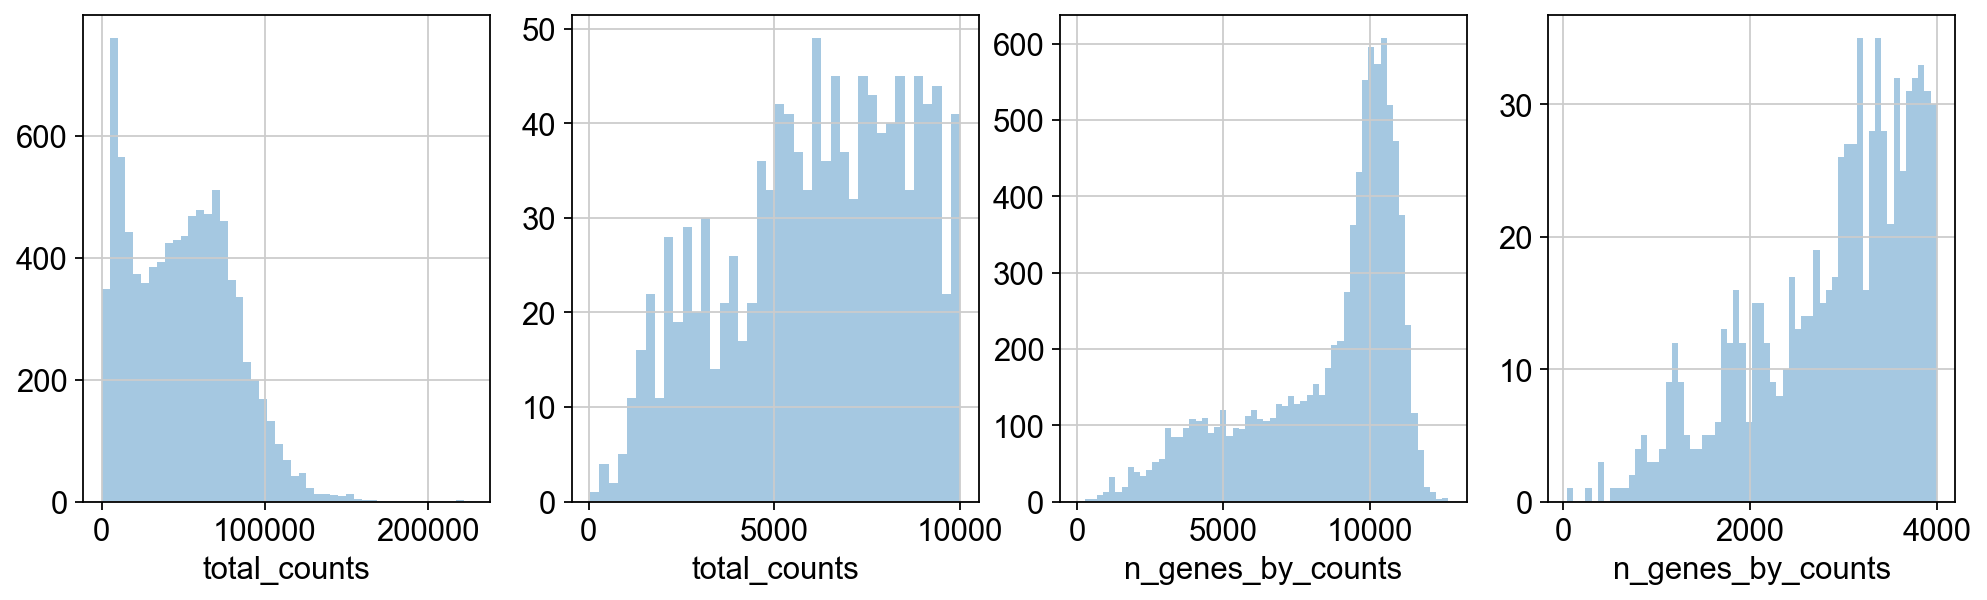

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
sns.distplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])

In [11]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

filtered out 72 cells that have less than 5000 counts
#cells after MT filter: 8996
filtered out 30 genes that are detected in less than 10 cells


/Users/xiaoding/.virtualenvs/env_scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [10]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
adata

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 9080 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg'
    obsm: 'spatial'

## Manifold embedding and clustering


In [20]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
running Leiden clustering
    finished: found 23 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/xiaoding/.virtualenvs/env_scanpy/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


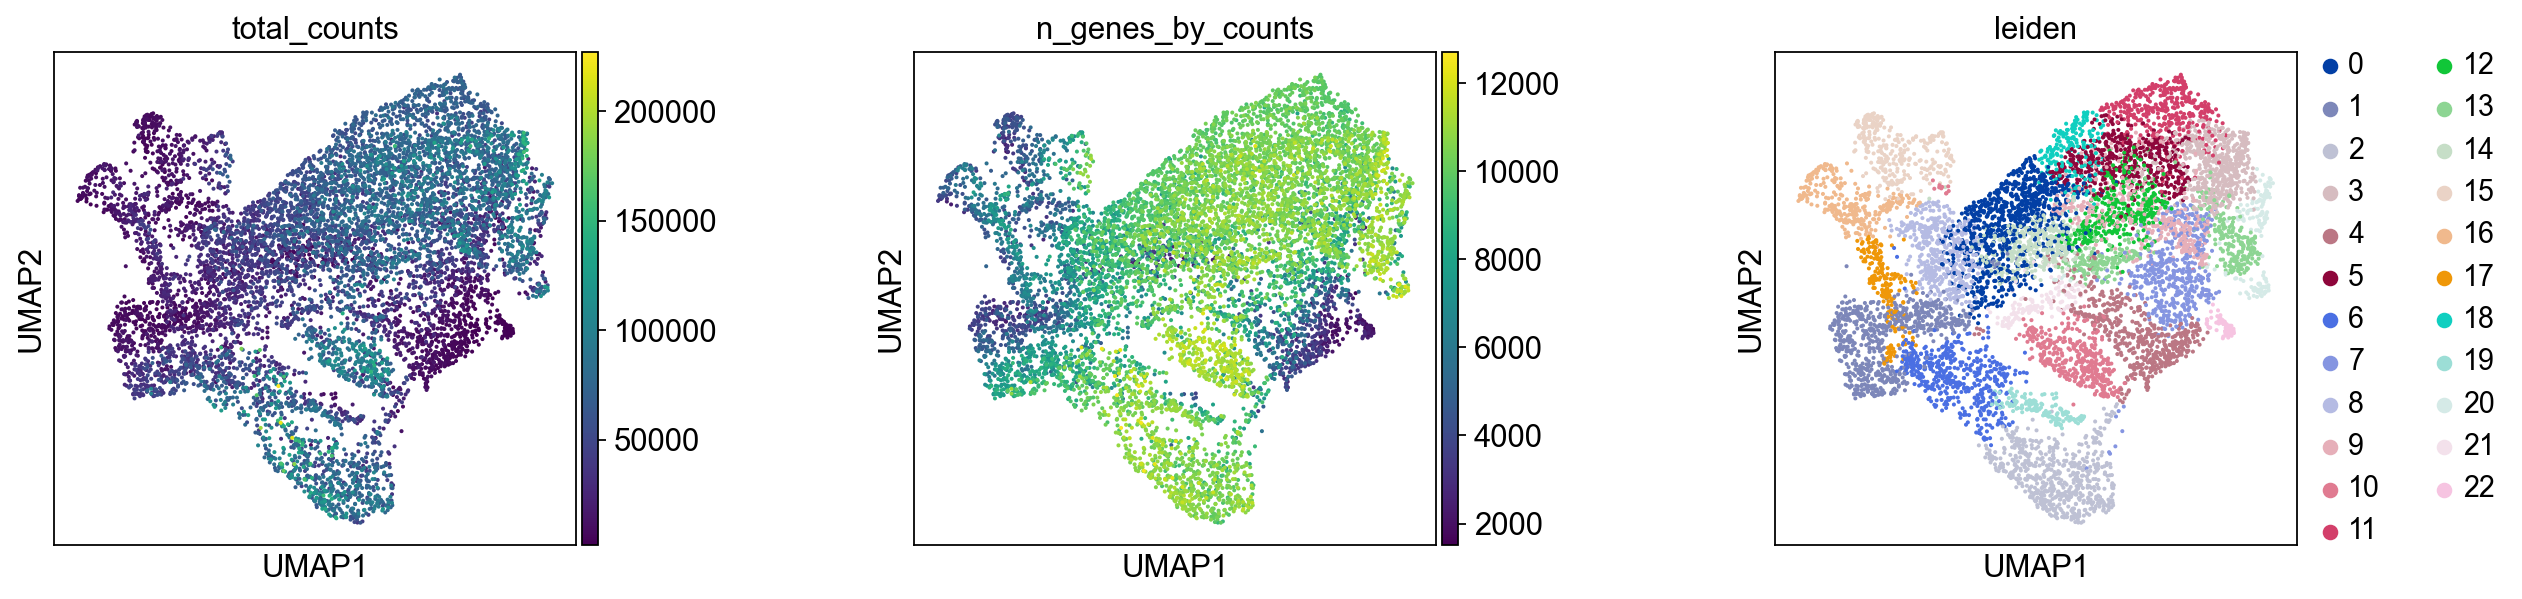

In [24]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "leiden"], wspace=0.5)

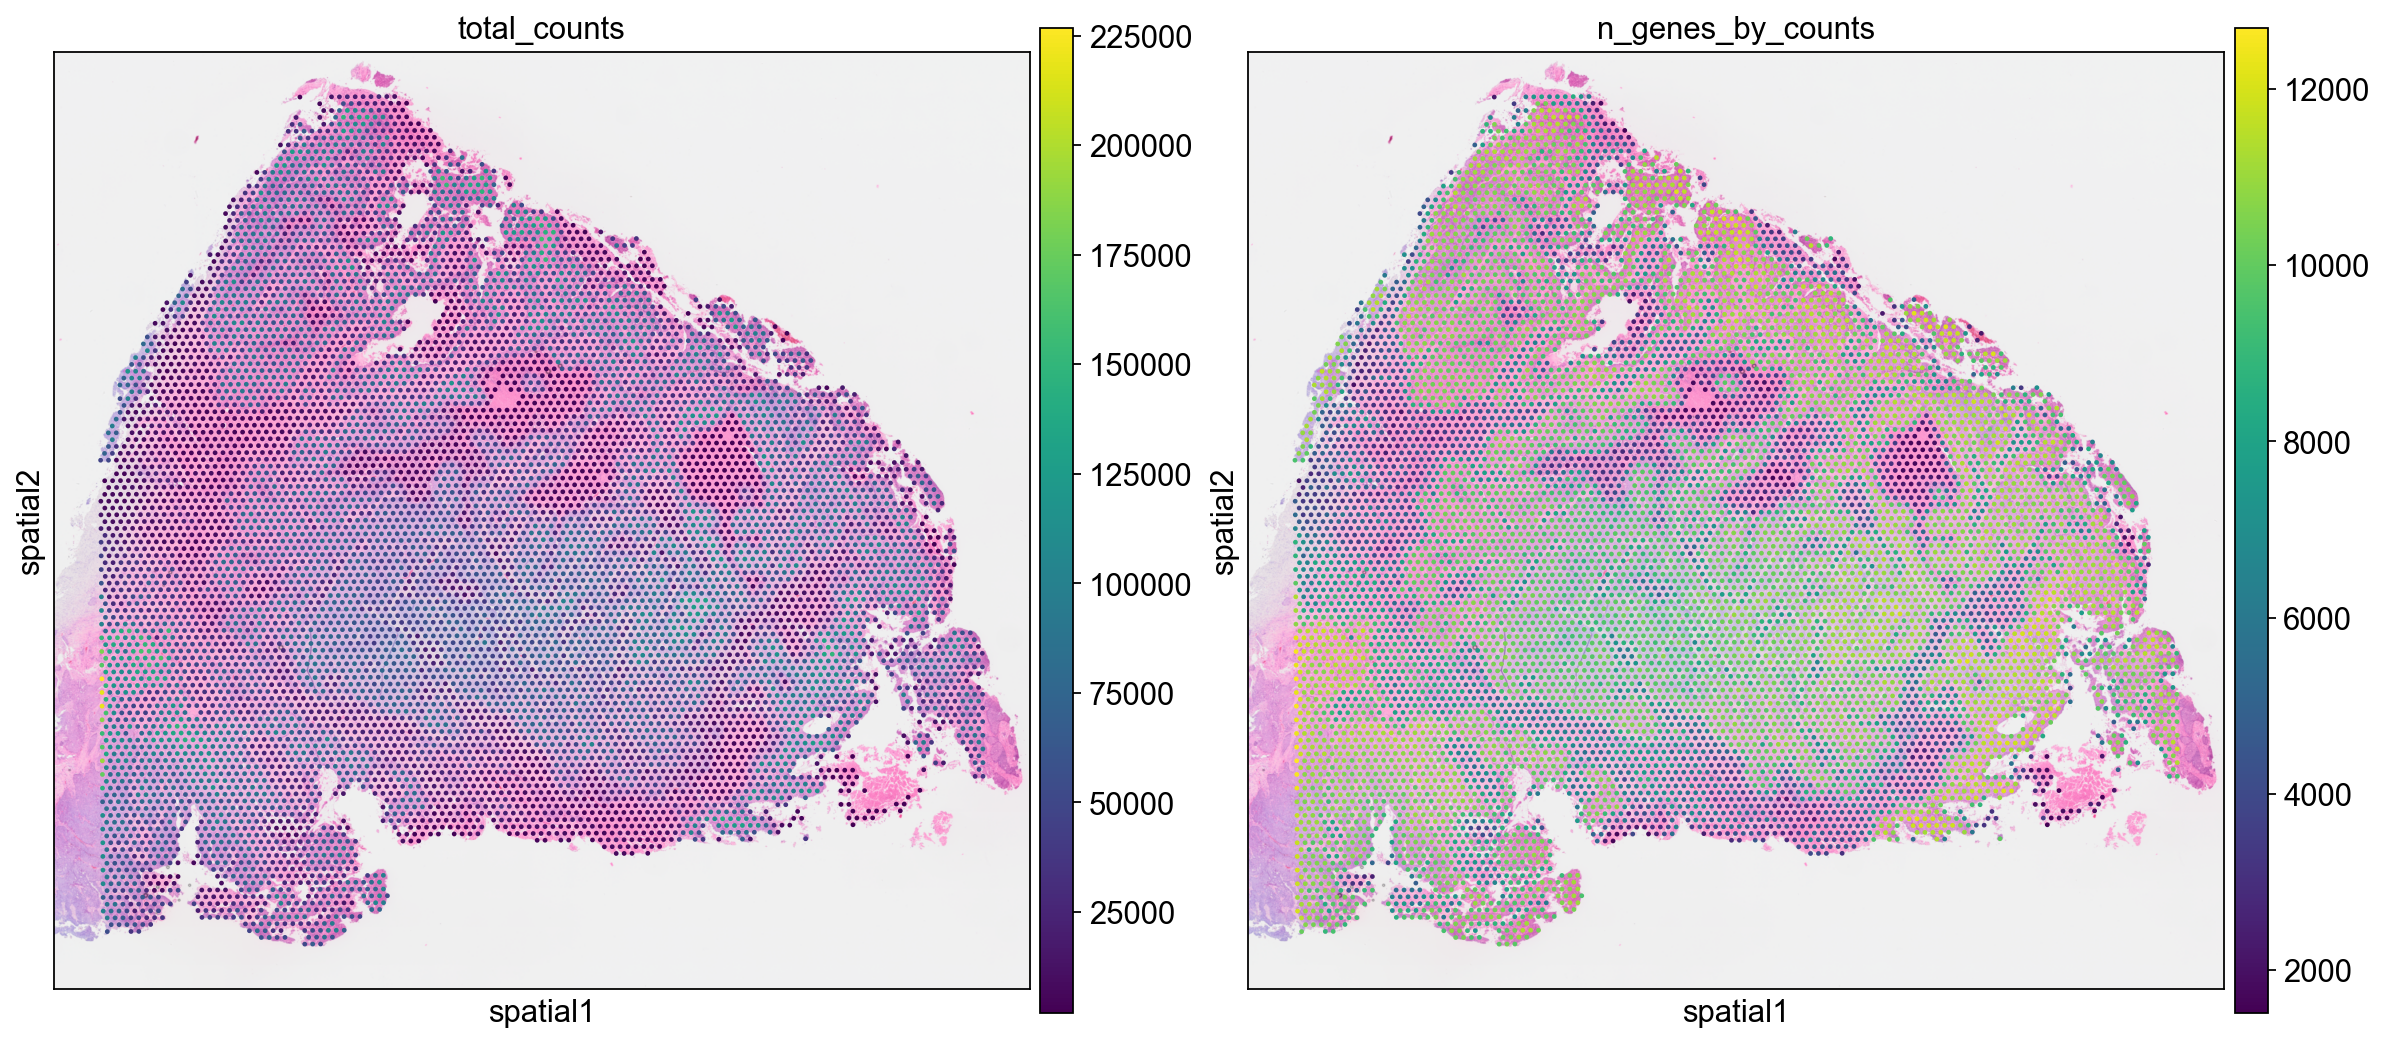

In [25]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

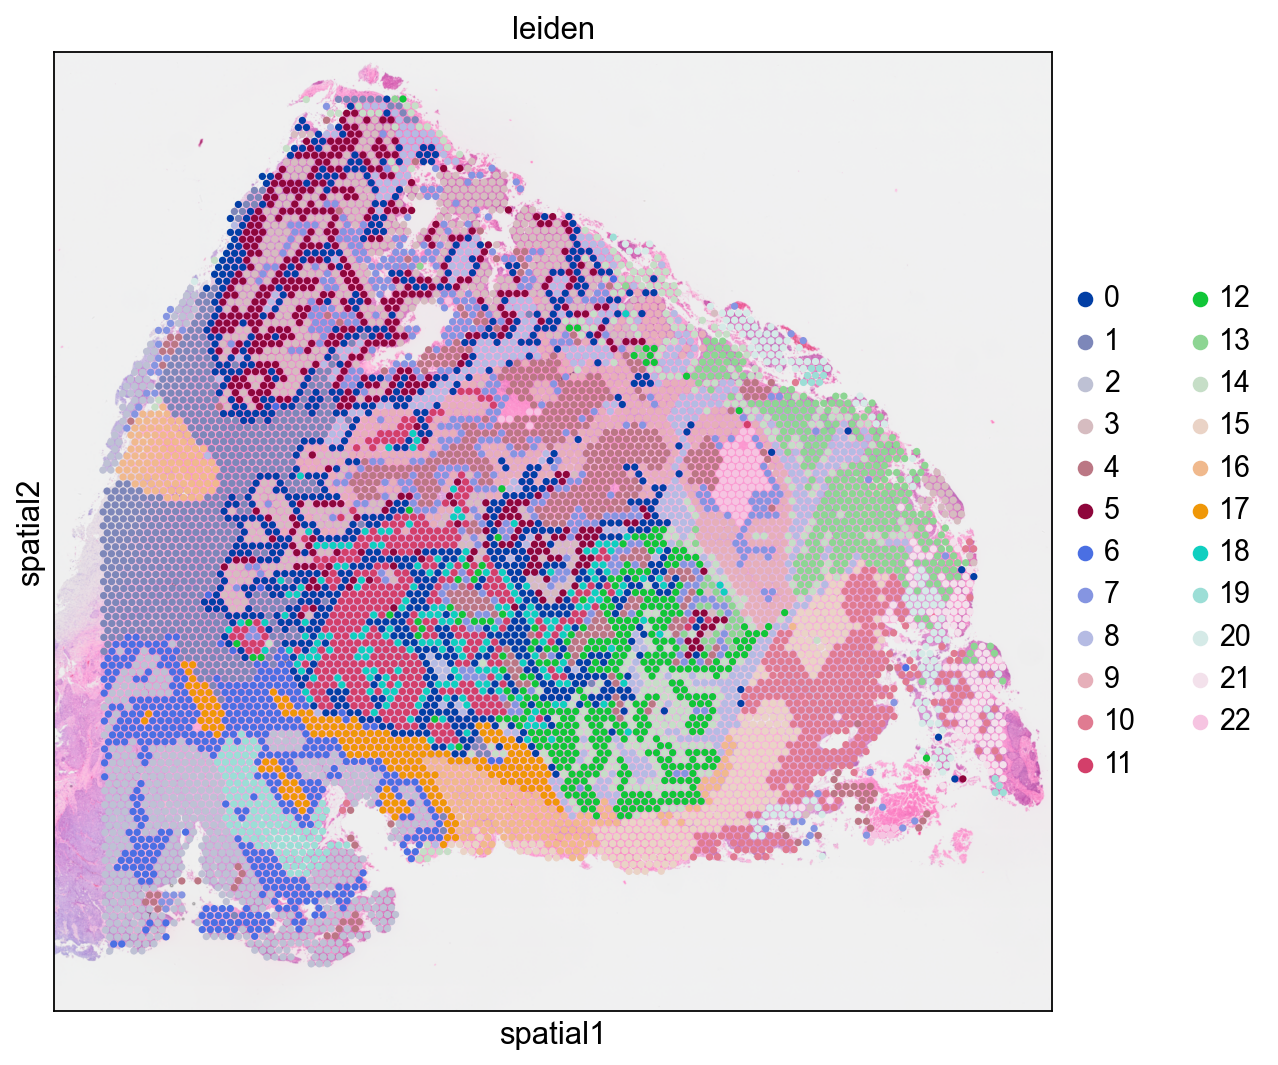

In [26]:
sc.pl.spatial(adata, img_key="hires", color="leiden", size=1.5)

normalizing counts per cell
    finished (0:00:01)


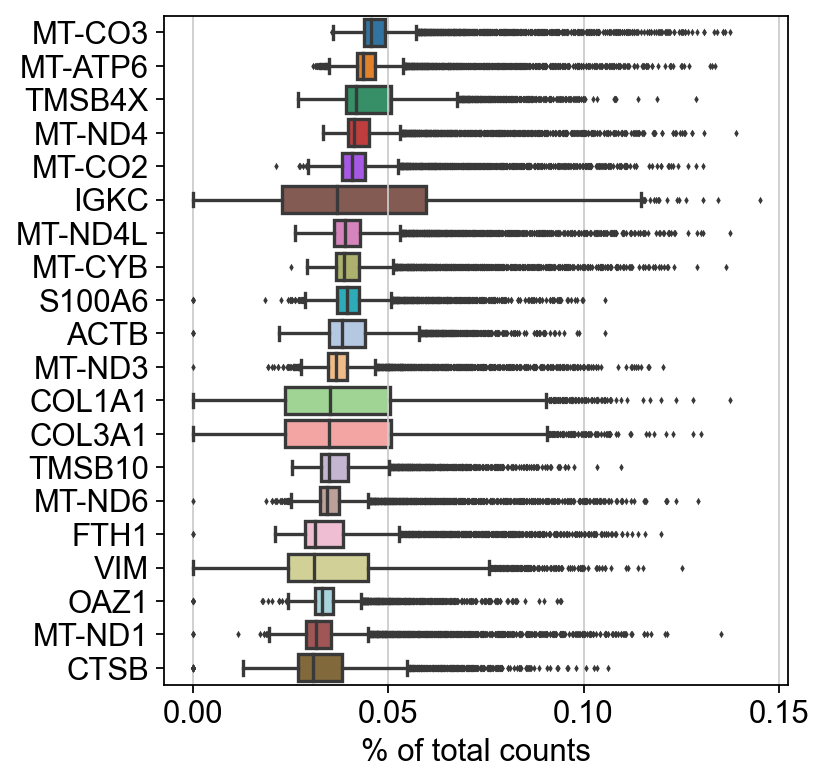

In [27]:
sc.pl.highest_expr_genes(adata, n_top=20)

# Identify highly variable genes

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


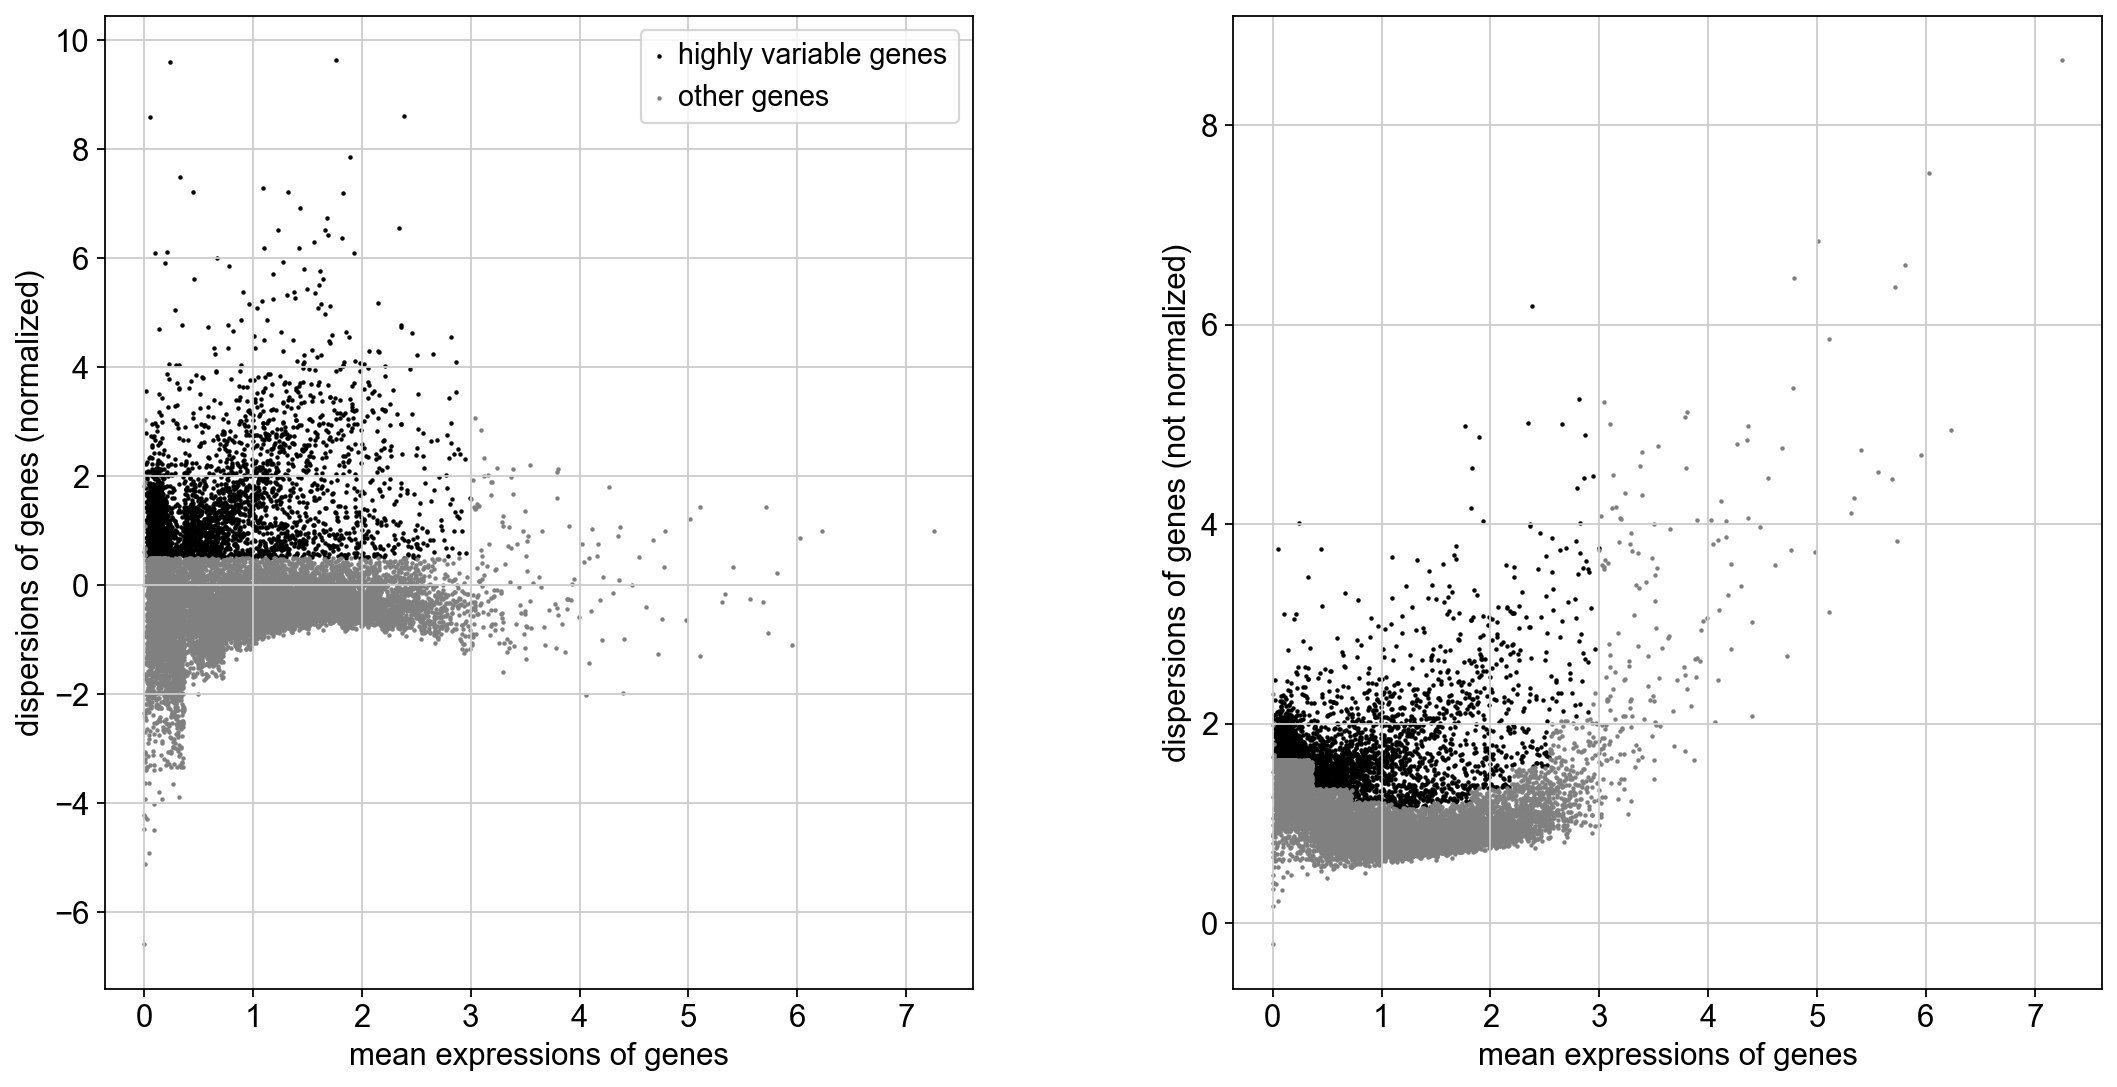

In [28]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

## Neighbors enrichment analysis

In [30]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)

Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)


In [31]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")

Calculating neighborhood enrichment using `1` core(s)


100%|██████████| 1000/1000 [00:05<00:00, 168.77/s]


Adding `adata.uns['leiden_nhood_enrichment']`
Finish (0:00:06)


/Users/xiaoding/.virtualenvs/env_scanpy/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


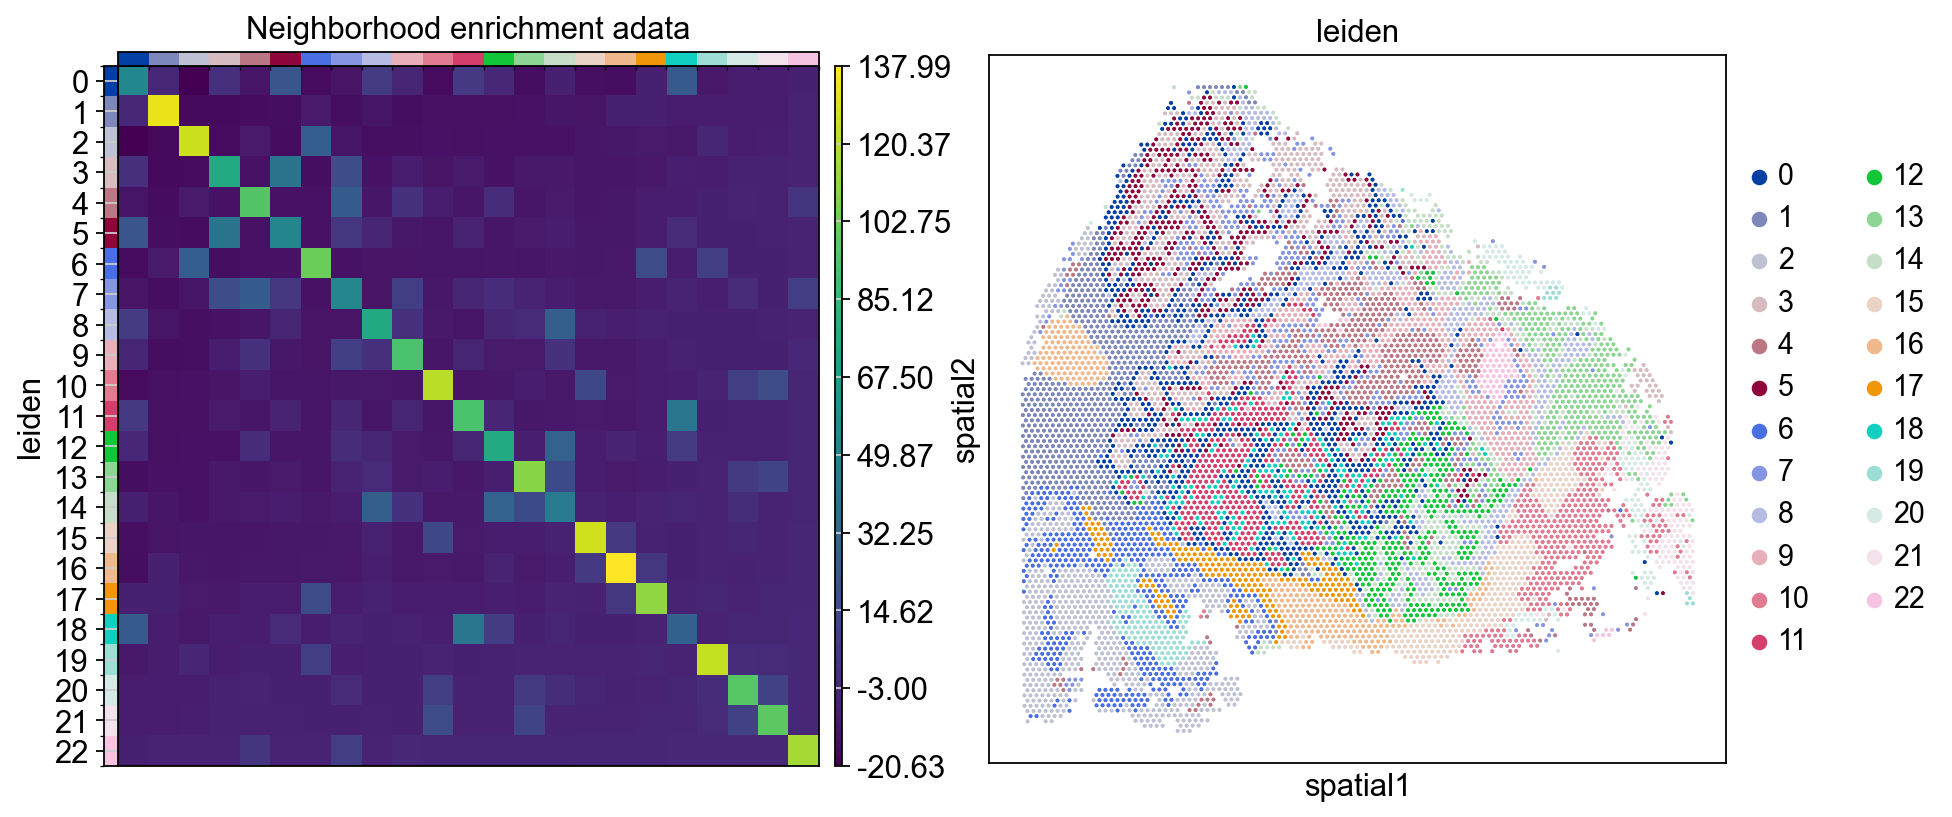

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(13, 7))
sq.pl.nhood_enrichment(
    adata,
    cluster_key="leiden",
    figsize=(8, 8),
    title="Neighborhood enrichment adata",
    ax=ax[0],
)
sq.pl.spatial_scatter(adata, color="leiden", shape=None, size=2, ax=ax[1])

In [34]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)
adata_subsample.uns["moranI"].head(10)

Creating graph using `generic` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating moran's statistic for `100` permutations using `1` core(s)


  6%|▌         | 6/100 [00:59<14:39,  9.35s/]

In [ ]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "DES",
        "IGHG3",
        "ELN",
    ],
    shape=None,
    size=2,
    img=False,
)